In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
import os

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, roc_auc_score

from tqdm.notebook import tqdm

In [3]:
df = pd.read_csv('clean_vizathon.csv', index_col=0)

/Users/jared/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
display(df.head(3))
print(df.shape)

,index,game_id,season,day_num,date,team_id,team_name,team_city,team_state,team_dist_from_home,...,opp_blks,opp_pfs,opp_poss,opp_elo_before_game,opp_elo_after_game,opp_elo_win_prob,team_off_eff,team_def_eff,opp_off_eff,opp_def_eff
0,184715,2003_2002-11-14_1104_1328,2003,10,2002-11-14,1328,Oklahoma,Norman,OK,,...,1,22,47,700.0,712.0,0.5,100.000000,109.677419,109.677419,100.000000
1,184714,2003_2002-11-14_1104_1328,2003,10,2002-11-14,1104,Alabama,Tuscaloosa,AL,,...,2,20,48,700.0,688.0,0.5,109.677419,100.000000,100.000000,109.677419
2,161722,2003_2002-11-14_1272_1393,2003,10,2002-11-14,1272,Memphis,Memphis,TN,,...,6,16,64,700.0,688.0,0.5,83.333333,75.000000,75.000000,83.333333


(184940, 58)


In [5]:
df = df.applymap(lambda x:  x.strip() if isinstance(x, str) else x)

#### Note:
Each game is basically duplicated with the two opposing teams each considered once 'team' and once 'opponent'. 
These should be removed.

In [6]:
df.drop_duplicates(subset='game_id',inplace=True)

In [7]:
df.shape

(92470, 58)

### Create a simple logistic regression model.

The baseline accuracy is 70% (simple Elo win probability).

To make statistcal inferences about the model's coefficients, must verify assumptions:
1. Dependent variable(win/lose) is binary. 
2. Observations must be independent of each other (no matched data, e.g. delete duplicate game IDs)
3. Multicollinearity must be small or none  among the independent variables
4. Independent variables are linearly related to the log odds (not to dependent variable)
5. Large enough sample size for number of independent variables considered

In [347]:
# Engineer simple column, 'difference between elo'
df['team_diff_elo'] = df.team_elo_before_game - df.opp_elo_before_game
# preview
df[['team_elo_before_game', 'opp_elo_before_game', 'team_diff_elo']].iloc[200:205]

,team_elo_before_game,opp_elo_before_game,team_diff_elo
398,700.0,688.000000,12.000000
400,700.0,700.000000,0.000000
402,688.0,713.102126,-25.102126
404,688.0,700.000000,-12.000000
407,700.0,712.000000,-12.000000


### Running averages for stats each season

Each season is considered a fresh slate. However, if it is the first game of the season, the final average of the previous season is used. By the second game, though, the performance from the first game will be the new and only term in the running average.

In [251]:
def rolling_avg_per_season(df, df_grouped, col: str):
    "Return df with column 'avg_{col}' based on the rolling average of df[col] per season"
    gg = df_grouped[col].rolling(window=365, freq='D',min_periods=1).mean().reset_index()
    return df.merge(gg.rename(columns={col: "avg_"+col}))

In [252]:
cols_to_avg = ['team_off_eff', 'team_def_eff', 
                'team_fgm', 'team_3pm', 'team_ftm',
                'team_off_rebs', 'team_def_rebs', 'team_tos']

col_map = {col: "avg_"+col for col in cols_to_avg}
col_include = [v for v in col_map.values()]

In [253]:
df_grouped = df.set_index('game_id').groupby(['team_id', 'season'])

In [254]:
gg = df_grouped[cols_to_avg].rolling(window=2, min_periods=1).mean().shift().reset_index()
gg.rename(columns=col_map, inplace=True)

In [256]:
gg[gg.isnull().any(axis=1)]

,team_id,season,game_id,avg_team_off_eff,avg_team_def_eff,avg_team_fgm,avg_team_3pm,avg_team_ftm,avg_team_off_rebs,avg_team_def_rebs,avg_team_tos
0,1101,2014,2014_2013-11-09_1182_1101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
df2 = df.merge(gg.dropna(axis=0, how='any'))

In [260]:
columns = col_include + ['team_diff_elo']
X = df2[columns]
y = df2.team_win
X

,avg_team_off_eff,avg_team_def_eff,avg_team_fgm,avg_team_3pm,avg_team_ftm,avg_team_off_rebs,avg_team_def_rebs,avg_team_tos,team_diff_elo
0,83.603896,84.387352,23.0,4.0,20.0,11.0,23.0,10.0,0.000000
1,95.138889,101.157407,23.5,7.0,18.0,15.0,23.5,16.5,0.000000
2,79.821429,88.541667,26.0,8.0,5.5,8.0,27.0,16.0,0.000000
3,80.922182,76.673660,27.5,8.0,19.5,11.5,30.0,11.5,0.000000
4,84.992690,73.669591,25.5,8.5,11.5,9.0,26.5,9.0,0.000000
...,...,...,...,...,...,...,...,...,...
92464,80.259870,82.683658,28.5,6.5,8.5,10.0,25.0,10.5,-84.154171
92465,81.322537,90.134953,27.0,5.5,11.0,7.5,24.0,15.0,-8.093072
92466,83.579545,84.034091,25.5,5.5,13.0,6.0,28.0,13.5,77.378549
92467,65.062112,91.713251,24.5,4.0,11.5,11.5,22.5,11.0,-135.668975


In [261]:
X.describe()

,avg_team_off_eff,avg_team_def_eff,avg_team_fgm,avg_team_3pm,avg_team_ftm,avg_team_off_rebs,avg_team_def_rebs,avg_team_tos,team_diff_elo
count,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000,92469.000000
mean,89.698939,89.662875,24.408191,6.622046,14.097725,10.962122,23.786437,13.700797,0.274742
std,12.702162,12.897140,3.882093,2.373679,4.691886,3.290650,4.032942,3.395416,107.187132
min,38.805970,36.764706,6.000000,0.000000,0.000000,0.000000,8.000000,3.000000,-504.387766
25%,81.155633,80.977221,22.000000,5.000000,11.000000,8.500000,21.000000,11.500000,-65.861607
50%,88.698439,88.664549,24.000000,6.500000,14.000000,11.000000,23.500000,13.500000,0.000000
75%,97.129748,97.192879,27.000000,8.000000,17.000000,13.000000,26.500000,16.000000,66.586779
max,192.294372,205.800866,52.000000,22.000000,45.000000,32.000000,48.000000,37.000000,509.305507


In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11db56e80>,
      dtype=object)

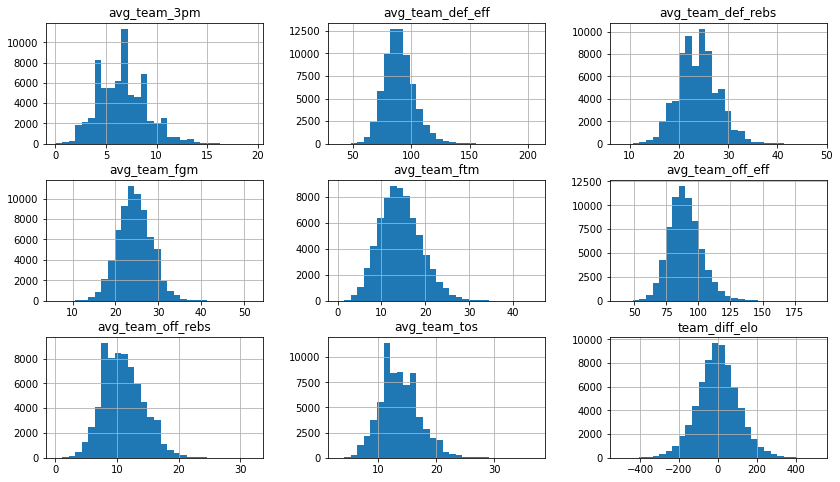

In [264]:
X_train.hist(bins=30, figsize=(14, 8))

In [346]:
LR = LogisticRegression(random_state=10)
LR.fit(X_train, y_train)

y_train_preds = LR.predict(X_train)

In [308]:
print('accuracy_score: ', accuracy_score(y_train, y_train_preds))
print('recall_score: ', recall_score(y_train, y_train_preds))
print('precision_score: ', precision_score(y_train, y_train_preds))

accuracy_score:  0.7009127481939698
recall_score:  0.6936281640965959
precision_score:  0.7001057206625162


Text(0, 0.5, "Difference from Opponent's Elo")

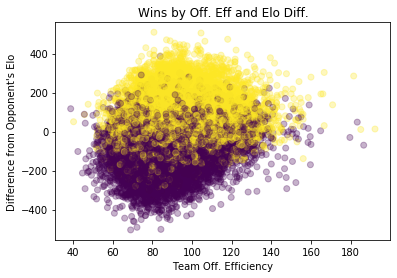

In [310]:
fig, ax = plt.subplots()

ax.scatter(X_train['avg_team_off_eff'], X_train['team_diff_elo'], c=y_train, alpha=.3)
ax.set_title('Wins by Off. Eff and Elo Diff.')
ax.set_xlabel('Team Off. Efficiency')
ax.set_ylabel("Difference from Opponent's Elo")

In [331]:
feat_coef = pd.DataFrame(index=X.columns, data=LR.coef_[0], columns=['LR_coef'])
feat_coef['abs_coef'] = abs(feat_coef['LR_coef'])
feat_coef.sort_values(by='abs_coef', ascending=False)

,LR_coef,abs_coef
avg_team_off_rebs,0.014208,0.014208
avg_team_def_rebs,-0.012910,0.012910
team_diff_elo,0.011872,0.011872
avg_team_fgm,0.006157,0.006157
avg_team_off_eff,0.005395,0.005395
avg_team_def_eff,-0.004794,0.004794
avg_team_ftm,-0.002937,0.002937
avg_team_tos,-0.001721,0.001721
avg_team_3pm,-0.001344,0.001344


In [332]:
y_pred = LR.predict(X_test)

In [334]:
print('accuracy_score: ', accuracy_score(y_test, y_pred))
print('recall_score: ', recall_score(y_test, y_pred))
print('precision_score: ', precision_score(y_test, y_pred))

accuracy_score:  0.6981140237044727
recall_score:  0.6934712015040164
precision_score:  0.7052229077952551


In [336]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70     11416
           1       0.71      0.69      0.70     11702

    accuracy                           0.70     23118
   macro avg       0.70      0.70      0.70     23118
weighted avg       0.70      0.70      0.70     23118



### Trying Multiple Models

In [337]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
 

In [338]:
def plot_roc(ax, df, name):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label=name)
#     ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.set_title('ROC Curve - Model Comparison', fontweight='bold', fontsize=24)
    ax.legend(fontsize=14)

In [343]:
def modelling(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    probs = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, probs)
    thresh_df = calculate_threshold_values(probs, y_test)

    return (precision, recall, accuracy, thresh_df, roc_auc, model)

In [340]:
# initializing models

logistic = LogisticRegression()
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
kn = KNeighborsClassifier()
model_list = [logistic, gb, rf, dt, kn]

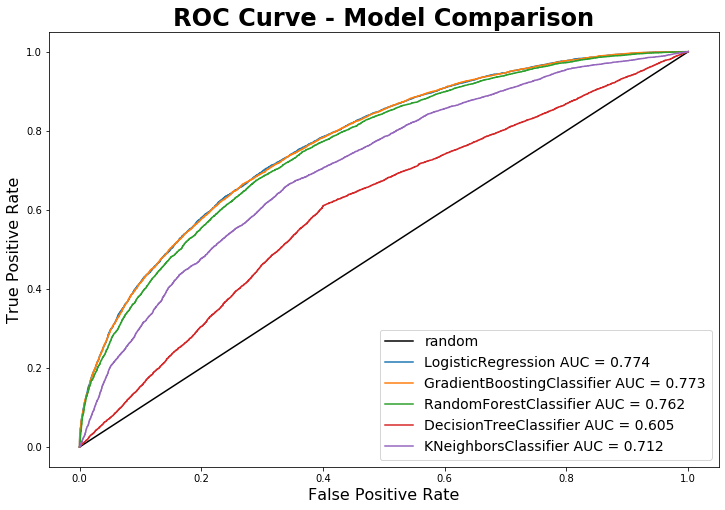

In [345]:
## Fitting and testing models
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([0,1],[0,1], 'k', label="random")
res_list = []

for model in model_list:
    results = modelling(X_train, X_test, y_train, y_test, model)
    res_list.append(results)
    auc_score = results[4]
    plot_roc(ax, results[3], 
             "{} AUC = {}".format(model.__class__.__name__, round(auc_score, 3)))

In [349]:
gb.feature_importances_

array([0.00929102, 0.00418885, 0.00253009, 0.00163447, 0.00210467,
       0.00314433, 0.00205588, 0.00256838, 0.97248231])

In [351]:
importances = gb.feature_importances_
std = np.std([gb.feature_importances_ for tree in gb.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]



In [353]:
gb.estimators_

array([[DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=RandomState(MT19937) at 0x10F917678,
                      splitter='best')],
       [DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=RandomState(MT19937) at 0x10F917678,
                      splitter='best')],
       [DecisionTreeRegressor(ccp_alpha=0.0, criterion='frie